In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from locale import atof
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC


In [2]:

def parseFloatValue(x):
    return x.replace(',', '.')
    
def parsPercentValue(x):
    return x.replace('%', '').replace(',', '.')

def parseNdValue(x):
    if (x == 'n/d'):
        return '0,0'
    else:
        return x

def parseMValue(x):
    if ('M' in x):
        return str(float(x.replace('M','').replace(',', '.')) *  1000000)
    else:
        return x
        
def fit_and_predict(nome, modelo, treino_dados, treino_marcacoes):
    K = 50
    scores = cross_val_score(modelo, treino_dados, treino_marcacoes, cv = K)
    msg = 'Taxa de acerto do {0}: {1}%'.format(nome, round(np.mean(scores) * 100,2))
    print(msg)
    return np.mean(scores)

In [3]:
#Lendo csv dos dados da ITSA4
dados = pd.read_csv("./itsa4-historico.csv", delimiter=',')

In [4]:
# Muda o tipo dos dados
dados['ABERTURA'] = dados['ABERTURA'].apply(parseNdValue).apply(parseFloatValue).map(atof)
dados['FECHAMENTO'] = dados['FECHAMENTO'].apply(parseFloatValue).map(atof)
dados['VARIAÇÃO'] = dados['VARIAÇÃO'].apply(parseFloatValue).map(atof)
dados['MÍNIMO'] = dados['MÍNIMO'].apply(parseFloatValue).map(atof)
dados['MÁXIMO'] = dados['MÁXIMO'].apply(parseFloatValue).map(atof)
dados['VOLUME'] = dados['VOLUME'].apply(parseMValue).map(atof)
dados["DATA"] = pd.to_datetime(dados["DATA"], format='%d/%m/%Y')

dados = dados.sort_values(by="DATA")
dados = dados.reset_index(drop=True)

In [5]:
#Lendo csv dos dados do dolar
dolar = pd.read_csv("./dolar.csv", delimiter=',')
dolar["Data"] = pd.to_datetime(dolar["Data"], format='%d.%m.%Y')
dolar['Último'] = dolar['Último'].apply(parseNdValue).apply(parseFloatValue).map(atof)
dolar = dolar.sort_values(by="Data")
dolar = dolar.reset_index(drop=True)

In [6]:
# Adicionando preço do dolar 
a_renomear = {
    'Data' : 'DATA',
    'Var%' : 'VARIACAO_DOLAR'
}
dolar = dolar.rename(columns = a_renomear)
dataFrameAux = pd.merge(dados, dolar, how='left', indicator='Exist')
dataFrameAux['Exist'] = np.where(dataFrameAux.Exist == 'both', True, False)
dados = dataFrameAux[dataFrameAux['Exist']==True].drop(['Exist', 'Abertura', 'Máxima', 'Mínima'], axis=1)
dados = dados.rename(columns = { 'Último': 'DOLAR' })

In [7]:
#Empurrando para frente os valores das ações
dados['FECHAMENTO_PROXIMO_DIA'] = dados['FECHAMENTO'].shift(-1)
dados['FECHAMENTO_DOLAR_PROXIMA_SEMANA'] = dados['DOLAR'].shift(-7)
dados['VARIACAO_DOLAR'] = dados['VARIACAO_DOLAR'].apply(parsPercentValue).map(atof)

In [8]:
#retirando os dados nulos
dados.dropna(inplace=True)
dados = dados.reset_index(drop=True)

In [9]:
# Definindo a regra de compra e venda baseado no fechamento do próximo dia da ação e do dolar
dados['COMPRA'] = dados.apply(
    lambda row: (1 if (row['FECHAMENTO'] < row['FECHAMENTO_PROXIMO_DIA']) else 0), axis=1)

249 vendas
239 compras


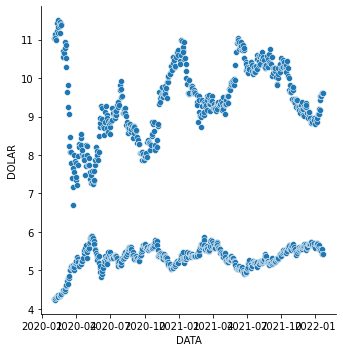

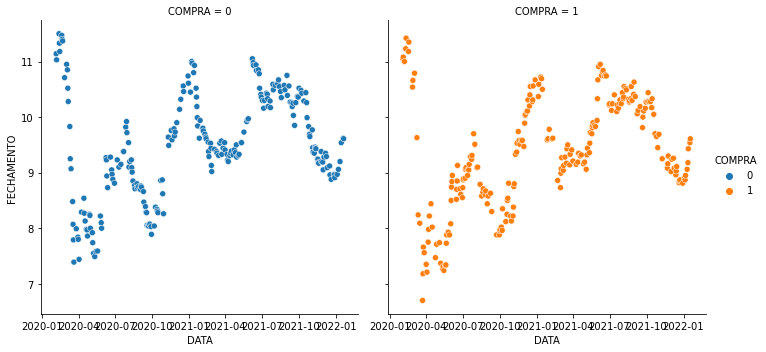

In [10]:
print(len(dados[dados['COMPRA'] == 0]), 'vendas')
print(len(dados[dados['COMPRA'] == 1]), 'compras')
sns.relplot(x="DATA", y="DOLAR", data=dados)
sns.scatterplot(x="DATA", y="FECHAMENTO", data=dados)
sns.relplot(x="DATA", y="FECHAMENTO", hue="COMPRA", col="COMPRA", data=dados)

In [11]:

#separando as features e labels
features = dados.drop(['DATA', 'COMPRA'], 1)
labels = dados['COMPRA']

#Escolhendo as melhores features com Kbest
features_list = ('ABERTURA','VARIAÇÃO','MÍNIMO','MÁXIMO', 'VOLUME', 'FECHAMENTO', 'DOLAR', 'VARIACAO_DOLAR', 'FECHAMENTO_DOLAR_PROXIMA_SEMANA')

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()
print ('')
print ("Melhores features:")
print (k_best_features_final)


Melhores features:
{'MÁXIMO': 8.295971247444063, 'FECHAMENTO_DOLAR_PROXIMA_SEMANA': 5.916447185306852, 'VARIAÇÃO': 2.266782332340769, 'MÍNIMO': 1.795388480199603, 'FECHAMENTO': 1.196898933113662, 'VARIACAO_DOLAR': 1.109883748218294, 'VOLUME': 1.046273341172467, 'DOLAR': 0.24012628115414214}


/tmp/ipykernel_7254/3811540322.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features = dados.drop(['DATA', 'COMPRA'], 1)


In [12]:
x = dados[['VARIACAO_DOLAR', 'MÁXIMO', 'VARIAÇÃO',  'FECHAMENTO']]
y = dados["COMPRA"]

In [13]:
# Separando os dados usando o train_test_split
SEED = 5
np.random.seed(SEED)
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, 
    random_state = SEED, 
    test_size = 0.20,
    stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

Treinaremos com 390 elementos e testaremos com 98 elementos


In [14]:
# Separando os dados para validação cruzada
train_percent = 0.8

train_len = int(train_percent * len(y))
train_x_cross_validation = x[0:train_len]
train_y_cross_validation = y[0:train_len]

test_x_cross_validation = x[train_len:]
test_y_cross_validation = y[train_len:]

In [15]:
from sklearn.dummy import DummyClassifier

dummy_stratified = DummyClassifier(strategy='stratified')
dummy_stratified.fit(treino_x, treino_y)
previsoes = dummy_stratified.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia do dummy foi %.2f%%" % acuracia)

A acurácia do dummy foi 53.06%


In [16]:
modelOneVsOneSvc = OneVsOneClassifier(SVC(random_state=0))
resultModelOneVsOneSvc = fit_and_predict("OneVsOneSvc", modelOneVsOneSvc, train_x_cross_validation, train_y_cross_validation.values.ravel())

Taxa de acerto do OneVsOneSvc: 55.11%


In [17]:
modelOneVsOneDecisiontree = OneVsOneClassifier(DecisionTreeClassifier(random_state=0))
resultModelOneVsOneDecisiontree = fit_and_predict("OneVsOneDecisionTreeClassifier", modelOneVsOneDecisiontree, train_x_cross_validation, train_y_cross_validation.values.ravel())

Taxa de acerto do OneVsOneDecisionTreeClassifier: 46.0%


In [18]:
modelOneVsOneDecisiontree.fit(train_x_cross_validation, train_y_cross_validation)
previsoes = modelOneVsOneDecisiontree.predict(test_x_cross_validation)
print(previsoes)
print(test_x_cross_validation.head(10))
acuracia = accuracy_score(test_y_cross_validation, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

[1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1
 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0
 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1]
     VARIACAO_DOLAR  MÁXIMO  VARIAÇÃO  FECHAMENTO
390           -0.30   10.48     -0.70       10.41
391           -0.67   10.66      2.12       10.63
392            0.71   10.80      1.04       10.75
393           -0.08   10.68     -3.34       10.39
394            0.20   10.49     -0.18       10.37
395           -0.44   10.62      1.87       10.56
396            2.94   10.51     -4.71       10.06
397           -2.33   10.32      2.01       10.27
398            0.92   10.39     -1.44       10.12
399           -0.58   10.36      1.37       10.26
A acurácia foi 46.94%


In [19]:
modelOneVsRestDecisiontree = OneVsRestClassifier(DecisionTreeClassifier(random_state=0))
resultModelOneVsRestDecisiontree = fit_and_predict("OneVsRestClassifier", modelOneVsRestDecisiontree, train_x_cross_validation, train_y_cross_validation.values.ravel())

Taxa de acerto do OneVsRestClassifier: 46.0%


In [20]:
# previsoes = modelo.predict(pd.DataFrame({'FECHAMENTO': [10.04], 'VARIAÇÃO': [-1.67], 'MÁXIMO': 9.99, 'MÍNIMO': 10.22 }))

# Treinando e prevendo com o train_test_split
modelo_svc = SVC()
modelo_svc.fit(treino_x, treino_y)
previsoes = modelo_svc.predict(teste_x)
print(previsoes)
acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

[0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0
 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1]
A acurácia foi 53.06%


[0 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1
 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1]
     VARIACAO_DOLAR  MÁXIMO  VARIAÇÃO  FECHAMENTO
118            0.42    9.46      0.77        9.31
195            0.00    9.55      1.72        9.53
163            1.80    8.34     -0.56        8.03
114           -1.05    9.34      1.46        9.29
255            0.06    9.67     -0.38        9.61
281            1.80    9.38     -2.05        9.14
230            1.81   11.05      3.84       11.00
374           -0.36   10.57      1.86       10.55
37             1.56    7.86     -5.35        7.56
325           -1.38    9.96     -1.29        9.83
A acurácia foi 48.98%


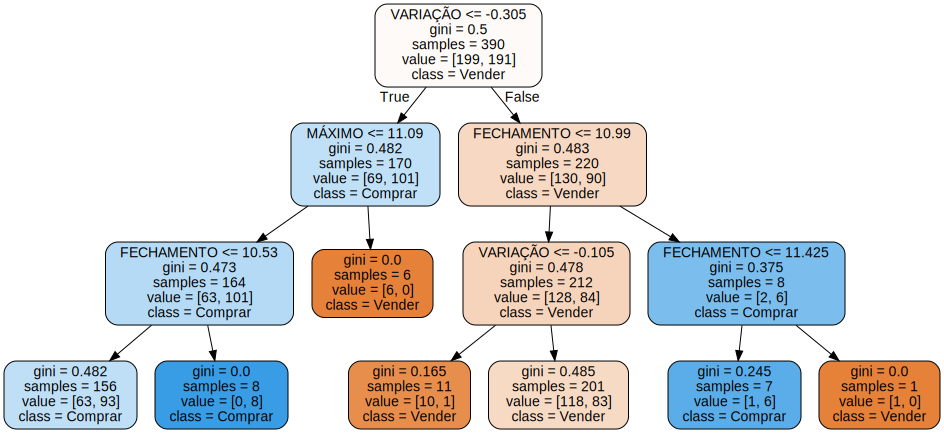

In [21]:
modelo = DecisionTreeClassifier(max_depth=3)
modelo.fit(treino_x, treino_y)
# previsoes = modelo.predict(pd.DataFrame({'FECHAMENTO': [10.04], 'VARIAÇÃO': [-1.67], 'MÁXIMO': 9.99, 'MÍNIMO': 10.22 }))
previsoes = modelo.predict(teste_x)
print(previsoes)
print(teste_x.head(10))
acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

features = x.columns
dot_data = export_graphviz(modelo, out_file=None,
    filled=True,
    rounded=True,
    feature_names=features,
    class_names=['Vender', 'Comprar'])
grafico = graphviz.Source(dot_data)
grafico